In [1]:
import datetime
import glob
import geopandas
import numpy
import pandas

from matplotlib import pyplot

In [2]:
import lib

# Previewing the data

In [3]:
HOBO_COLUMN_MAPPINGS = {
    "Date Time, GMT-04:00": "TIMESTAMP",
    "Temp, °F (LGR S/N: 20311528, SEN S/N: 20311528)": "TEMPERATURE_F",
    "RH, % (LGR S/N: 20311528, SEN S/N: 20311528)": "RELATIVE_HUMIDITY_PCT"
    # we ignore light intensity because that data is not useful
    # (light sensor was covered up by noise sensor)
}

labels = pandas.concat([pandas.read_csv(x) for x in glob.glob("./labels/*.csv")])
for time_column in ["START", "END"]:
    labels[time_column] = (labels[time_column] / 1000)

raw_data = pandas.concat([
    pandas.read_csv(part, skiprows=1)
    for part in glob.glob("./data_2018/*/20*.csv")
]).rename(HOBO_COLUMN_MAPPINGS, axis=1)[HOBO_COLUMN_MAPPINGS.values()]
raw_data["TIMESTAMP"] = pandas\
    .to_datetime(raw_data["TIMESTAMP"])\
    .apply(lambda dt: dt.timestamp() + 60*60*4) # 4 hour adjustment

sj = lib.SubwayJoiner()

labeled_data = sj.label_data(raw_data, labels)\
    .sort_values("TIMESTAMP").reset_index(drop = True)

df = labeled_data
df.sample(5)

/home/leaf/Desktop/school/subwaysurvey/lib/__init__.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["SAMPLE_ID"] = sample_id
/home/leaf/Desktop/school/subwaysurvey/lib/__init__.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["LOCATION"] = row["LOCATION"]
/home/leaf/Desktop/school/subwaysurvey/lib/__init__.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

,TIMESTAMP,TEMPERATURE_F,RELATIVE_HUMIDITY_PCT,SAMPLE_ID,LOCATION,STATUS,DIRECTION
15655,1.529634e+09,83.556,42.264,294,downtown crossing red to south station,left,1
36474,1.530238e+09,86.211,52.975,597,griggs street to harvard ave,left,0
13114,1.529467e+09,82.530,37.862,263,tufts medical center to back bay,left,1
16029,1.529634e+09,84.049,43.676,299,andrew,stopped,1
24340,1.529894e+09,79.173,46.483,104,park street green to boylston,left,1


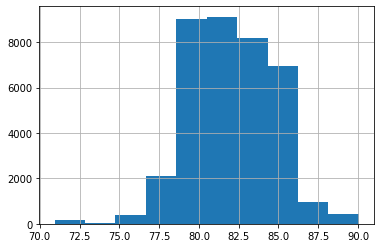

In [4]:
df["TEMPERATURE_F"].hist()

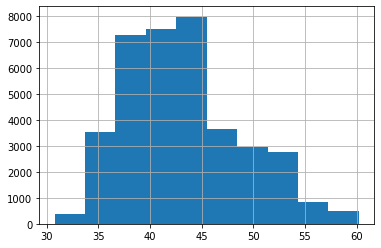

In [5]:
df["RELATIVE_HUMIDITY_PCT"].hist()

# Analysis

In [6]:
ESRI_TEMPLATE = "https://server.arcgisonline.com/ArcGIS/rest/services/%s/MapServer/tile/{z}/{y}/{x}"
ESRI_WORLD_STREET_MAP = ESRI_TEMPLATE % "World_Street_Map"
ESRI_WORLD_IMAGERY = ESRI_TEMPLATE % "World_Imagery"
ESRI_WORLD_LIGHT_GRAY_BASE = ESRI_TEMPLATE % "Canvas/World_Light_Gray_Base"

CARTODB_TEMPLATE = "https://a.basemaps.cartocdn.com/%s/{z}/{x}/{y}.png"
CARTODB_DARK = CARTODB_TEMPLATE % "dark_all"
CARTODB_DARK_NOLABELS = CARTODB_TEMPLATE % "dark_nolabels"
CARTODB_LIGHT = CARTODB_TEMPLATE % "light_all"
CARTODB_LIGHT_NOLABELS = CARTODB_TEMPLATE % "light_nolabels"

HOBO_AGGREGATES = {
    "TEMPERATURE_F": ["median", "mean", "max", "std", "count"],
    "RELATIVE_HUMIDITY_PCT": ["median", "mean", "max", "std", "count"]
}

In [7]:
(stations, segments) = sj.geospatial_join(df)

/home/leaf/Desktop/school/subwaysurvey/lib/__init__.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  .apply(lambda x: x[0])
/home/leaf/Desktop/school/subwaysurvey/lib/__init__.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  .apply(lambda x: x[1])


In [8]:
lib.export_all_aggregates(stations, segments, HOBO_AGGREGATES, "temperature")

In [9]:
lib.export_webapp_input(
    stations, segments,
    aggregates=HOBO_AGGREGATES,
    value_generators={
        "center": lambda row: row["TEMPERATURE_F.mean"],
        "upper": lambda row: row["TEMPERATURE_F.mean"] + row["TEMPERATURE_F.std"],
        "lower": lambda row: row["TEMPERATURE_F.mean"] - row["TEMPERATURE_F.std"]
    },
    metadata={
        "axis": "Temperature [°F]",
        "selection": "temperature (May 2018)",
        "center_desc": "Mean",
        "variability_desc": "Mean ± 1SD",
        "colormap": "inferno"
    },
    quantity="temperature"
)
lib.export_webapp_histograms(
    stations, segments, "TEMPERATURE_F", "temperature", 30
)

lib.export_webapp_input(
    stations, segments,
    aggregates=HOBO_AGGREGATES,
    value_generators={
        "center": lambda row: row["RELATIVE_HUMIDITY_PCT.mean"],
        "upper": lambda row: row["RELATIVE_HUMIDITY_PCT.mean"] + row["RELATIVE_HUMIDITY_PCT.std"],
        "lower": lambda row: row["RELATIVE_HUMIDITY_PCT.mean"] - row["RELATIVE_HUMIDITY_PCT.std"]
    },
    metadata={
        "axis": "Relative Humidity [%]",
        "selection": "relative humidity (May 2018)",
        "center_desc": "Mean",
        "variability_desc": "Mean ± 1SD",
        "colormap": "cividis"
    },
    quantity="humidity"
)
lib.export_webapp_histograms(
    stations, segments, "RELATIVE_HUMIDITY_PCT", "humidity", 30
)